##Extended Tiny NeRF
This is an extended version of Tiny NeRF from *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

Compared to Tiny NeRF, this version includes
*   5D input including view directions
*   Hierarchical Sampling

The overall architecture is adaptable to run on small GPUs (like colab's one).

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)



In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

import os, sys
import torch
from torch import nn

if IN_COLAB:
  !pip install imageio-ffmpeg
import imageio
from IPython.display import HTML
from base64 import b64encode
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


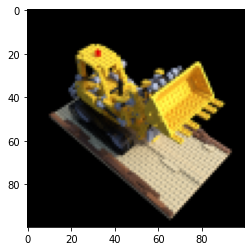

In [3]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# Optimize NeRF

In [4]:
def embed_fn(x, L_embed=6):
  rets = [x]
  for i in range(L_embed):
    for fn in [torch.sin, torch.cos]:
      rets.append(fn(2.**i * x))
  return torch.cat(rets, -1).to(device)

  
class NeRF(nn.Module):
    def __init__(self, useViewDirs=False, D=8, W=256, skip=[4], pos_embed=10, view_embed=4):
      super(NeRF, self).__init__()
      self.useViewDirs = useViewDirs
      inputSize = 3 + 3*2*pos_embed
      d_viewdirs = 3 + 3*2*view_embed
      self.inputLayer = nn.Linear(inputSize, W)
      self.hiddenLayers = nn.ModuleList() 
      for i in range(D-1):
        if i in skip:
          self.hiddenLayers.append(nn.Linear(W+inputSize, W))
        else:
          self.hiddenLayers.append(nn.Linear(W, W))
        
      if useViewDirs:
        self.alpha_out = nn.Linear(W, 1)
        self.rgb_filters = nn.Linear(W, W)
        self.branch = nn.Linear(W + d_viewdirs, W // 2)
        self.output = nn.Linear(W // 2, 3)
      else:
        self.outputLayer = nn.Linear(W, 4)

      self.skip = skip
  
    def forward(self, x, viewdirs=None):
      x_initial = x
      x = nn.functional.relu(self.inputLayer(x))
      for i, layer in enumerate(self.hiddenLayers):
        x = nn.functional.relu(layer(x))
        if i+1 in self.skip:
          x = torch.cat([x, x_initial], dim=-1)
      
      if self.useViewDirs:
        alpha = self.alpha_out(x)

        x = self.rgb_filters(x)
        x = torch.concat([x, viewdirs], dim=-1)
        x = nn.functional.relu(self.branch(x))
        x = self.output(x)

        x = torch.concat([x, alpha], dim=-1)
      else:
        x=self.outputLayer(x)
      return x

def sample_pdf(bins, weights, N_samples, det=False):

  # Get pdf
  weights += 1e-5  # prevent nans
  pdf = weights / torch.sum(weights, -1, keepdims=True)
  cdf = torch.cumsum(pdf, dim=-1)
  cdf = torch.cat([torch.zeros_like(cdf[..., :1]), cdf], -1)

  # Take uniform samples if det=False
  if det:
    u = torch.linspace(0., 1., N_samples, device=cdf.device)
    u = torch.broadcast_to(u, list(cdf.shape[:-1]) + [N_samples]) 
  else:
    u = torch.rand(list(cdf.shape[:-1]) + [N_samples], device=cdf.device) 

  # Invert CDF
  u = u.contiguous() #otherwise torch.searchsorted is not happy
  inds = torch.searchsorted(cdf, u, right=True) 
  below = torch.clamp(inds - 1, min=0)
  above = torch.clamp(inds, max=cdf.shape[-1]-1)
  inds_g = torch.stack([below, above], dim=-1) 
  shape = list(inds_g.shape[:-1]) + [cdf.shape[-1]]
  cdf_g = torch.gather(cdf.unsqueeze(-2).expand(shape), dim=-1, index=inds_g)
  bins_g = torch.gather(bins.unsqueeze(-2).expand(shape), dim=-1, index=inds_g)
  
  denom = (cdf_g[..., 1] - cdf_g[..., 0])
  denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
  t = (u - cdf_g[..., 0]) / denom
  samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

  return samples 


class full_NeRF(nn.Module):
    def __init__(self, near: float, far: float, useViewDirs=True, useHierarchicalSampling=True, pos_embed=10, view_embed=4, chunksize=2**15, rand_stratified_sampling=True, D_coarse=8, D_fine=8, skip_coarse=[4], skip_fine=[4], W_coarse=256, W_fine=258):
      super().__init__()
      self.near = near
      self.far = far
      self.useViewDirs = useViewDirs
      self.useHierarchicalSampling = useHierarchicalSampling
      self.rand_stratified_sampling = rand_stratified_sampling
      self.pos_embed = pos_embed
      self.view_embed = view_embed if useViewDirs else None;
      self.chunksize = chunksize
      self.coarse_model = NeRF(useViewDirs=useViewDirs, D=D_coarse, W=W_coarse, skip=skip_coarse, pos_embed=pos_embed, view_embed=view_embed)
      self.fine_model = NeRF(useViewDirs=useViewDirs, D=D_fine, W=W_fine, skip=skip_fine, pos_embed=pos_embed, view_embed=view_embed) if useHierarchicalSampling else None;
    
    def make_chunks_pos(self, points):
      points = points.reshape((-1, 3))
      points = embed_fn(points, L_embed=self.pos_embed)
      return [points[i:i + self.chunksize] for i in range(0, points.shape[0], self.chunksize)]

    def make_chunks_view(self, points, rays_d):
      viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
      viewdirs = viewdirs[:, None, ...].expand(points.shape).reshape((-1, 3))
      viewdirs = embed_fn(viewdirs, L_embed=self.view_embed)
      return [viewdirs[i:i + self.chunksize] for i in range(0, viewdirs.shape[0], self.chunksize)]

    def render_rays(self, raw, z_vals, rays_d):
      # Compute opacities and colors
      sigma_a = nn.functional.relu(raw[...,3])
      rgb = torch.sigmoid(raw[...,:3]) 
      
      # Do volume rendering
      dists = z_vals[..., 1:] - z_vals[..., :-1]
      dists = torch.cat([dists, torch.full(dists[..., :1].shape, 1e10, device=device)], dim=-1)
      dists = dists * torch.norm(rays_d[..., None, :], dim=-1) 
      alpha = 1.-torch.exp(-sigma_a * dists)  
      weights = torch.cumprod(1.-alpha + 1e-10, -1)
      weights = torch.roll(weights, 1, -1)
      weights[..., 0] = 1.
      weights =  alpha * weights

      rgb_map = torch.sum(weights[...,None] * rgb, -2) 

      return rgb_map, weights
    
    def forward(self, rays_o: torch.Tensor, rays_d: torch.Tensor):
      
      
      #Stratified sampling
      z_vals = torch.linspace(self.near, self.far, N_samples, device=device)
      z_vals = torch.broadcast_to(z_vals,list(rays_o.shape[:-1]) + [N_samples]).clone()
      if self.rand_stratified_sampling:
        z_vals += torch.rand(list(rays_o.shape[:-1]) + [N_samples], device=device) * (self.far-self.near)/N_samples
      pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

      chunks_pos = self.make_chunks_pos(pts)
      if self.useViewDirs:
        chunks_view = self.make_chunks_view(pts, rays_d)

      #coarse model pass
      predictions = []

      if self.useViewDirs:
        for chunk_pos, chunk_view in zip(chunks_pos, chunks_view):
          predictions.append(self.coarse_model(chunk_pos, chunk_view))
        
      else:
        for chunk_pos in chunks_pos:
          predictions.append(self.coarse_model(chunk_pos))
      
      raw = torch.cat(predictions, dim=0)
      raw = raw.reshape(list(pts.shape[:2]) + [raw.shape[-1]])

      rgb_map, weights = self.render_rays(raw, z_vals, rays_d)

      if not self.useHierarchicalSampling:
        del weights
        return rgb_map

      #Hierarchical sampling

      # Obtain additional integration times to evaluate based on the weights
      # assigned to colors in the coarse model.
      z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
      z_samples = sample_pdf(z_vals_mid, weights[..., 1:-1], N_samples_hierarchical, det=True)
      z_samples = z_samples.detach() #equivalent to tf.stop_gradient(z_samples)

      # Obtain all points to evaluate color, density at.
      z_vals_combined, _ = torch.sort(torch.cat([z_vals, z_samples], dim=-1), dim=-1)
      pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals_combined[..., :, None]  # [N_rays, N_samples + N_samples_hierarchical, 3]

      del rgb_map, weights 

      chunks_pos = self.make_chunks_pos(pts)
      if self.useViewDirs:
        chunks_view = self.make_chunks_view(pts, rays_d)

      #fine model pass
      predictions = []
      if self.useViewDirs:
        for chunk_pos, chunk_view in zip(chunks_pos, chunks_view):
          predictions.append(self.fine_model(chunk_pos, chunk_view))
      else:
        for chunk_pos in chunks_pos:
          predictions.append(self.fine_model(chunk_pos))

      raw = torch.cat(predictions, dim=0)
      raw = raw.reshape(list(pts.shape[:2]) + [raw.shape[-1]]) 

      rgb_map, _ = self.render_rays(raw, z_vals_combined, rays_d)

      return rgb_map



def get_rays(H, W, focal, c2w):
    c2w = torch.from_numpy(c2w).to(device)
    focal = torch.from_numpy(focal).to(device)
    i, j = torch.meshgrid(torch.arange(W, dtype=torch.float32, device=device), torch.arange(H, dtype=torch.float32, device=device), indexing="xy")
    dirs = torch.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -torch.ones_like(i)], -1)
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = torch.broadcast_to(c2w[:3,-1], rays_d.size())
    return rays_o, rays_d

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

Training model
0 0.05280011177062988 secs per iter


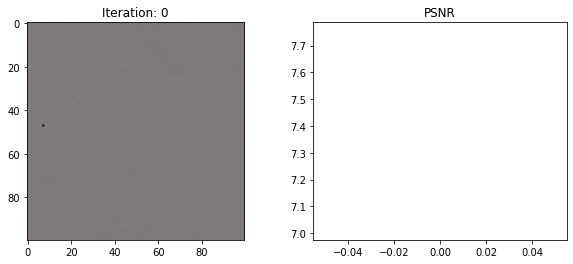

25 0.7957217979431153 secs per iter


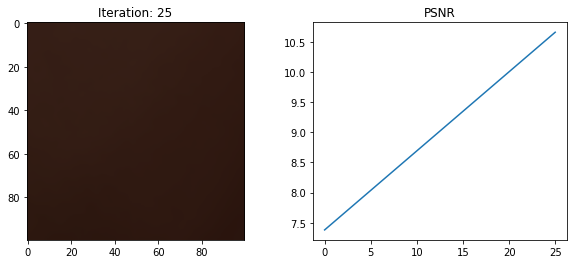

OutOfMemoryError: ignored

In [5]:
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25
loss_f = torch.nn.MSELoss()
load_model = False
true_NeRF = False
chunksize = 2**15


if not true_NeRF:
  ### Light model if on colab or on cpu (cpu is not recommended unless you have a lot of time)
  N_samples = 32
  N_samples_hierarchical = 32
  model = full_NeRF(2.0, 6.0, pos_embed=6, useViewDirs=False, useHierarchicalSampling=True, chunksize=chunksize, D_coarse=2, skip_coarse=[], D_fine=6, skip_fine=[3], W_coarse=128, W_fine=128, rand_stratified_sampling=False).to(device)
else:
  if device == 'cpu' or IN_COLAB:
    print("Warning: using full NeRF architecture on cpu or colab is not recommended. Set true_NeRF to False.")
  ### True NeRF model for strong GPUs
  N_samples = 64
  N_samples_hierarchical = 128
  model = full_NeRF(2.0, 6.0).to(device)

lr = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


if load_model:
    model.load_state_dict(torch.load('tiny_nerf_extended_trained.pt', map_location=device))
    model.eval()
    print('Model loaded')
else:
    print('Training model')
    import time
    t = time.time()
    for i in range(N_iters+1):
        model.train()
        img_i = np.random.randint(images.shape[0])
        target = images[img_i]
        pose = poses[img_i]
        height, width = target.shape[:2]
        target = torch.from_numpy(target).to(device)    
        rays_o, rays_d = get_rays(H, W, focal, pose)
        rays_o = rays_o.reshape(-1,3)
        rays_d = rays_d.reshape(-1,3)

        optimizer.zero_grad()
        rgb = model(rays_o, rays_d)
        rgb = rgb.reshape([height, width, 3])
        loss = loss_f(rgb, target)
        loss.backward()
        optimizer.step()
        del loss, rgb, target, rays_o, rays_d
        
        if i%i_plot==0:
            model.eval()
            print(i, (time.time() - t) / i_plot, 'secs per iter')
            t = time.time()
            
            # Render the holdout view for logging
            rays_o, rays_d = get_rays(H, W, focal, testpose)
            rays_o = rays_o.reshape(-1,3)
            rays_d = rays_d.reshape(-1,3)
            rgb = model(rays_o, rays_d)
            rgb = rgb.reshape([height, width, 3])
            loss = loss_f(rgb, torch.from_numpy(testimg).to(device))
            psnr = -10. * np.log10(loss.item())

            psnrs.append(psnr)
            iternums.append(i)
            
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            plt.imshow(rgb.cpu().detach().numpy())
            plt.title(f'Iteration: {i}')
            plt.subplot(122)
            plt.plot(iternums, psnrs)
            plt.title('PSNR')
            plt.show()
            del rgb, loss, psnr, rays_o, rays_d

    print('Done')
    #save model
    torch.save(model.state_dict(), 'tiny_nerf_extended_trained.pt')

# Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets

trans_t = lambda t : np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=np.float32)

rot_phi = lambda phi : np.array([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=np.float32)

rot_theta = lambda th : np.array([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=np.float32)

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]], dtype=np.float32) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rays_o = rays_o.reshape(-1,3)
    rays_d = rays_d.reshape(-1,3)
    rgb = model(rays_o, rays_d)
    rgb = rgb.reshape([height, width, 3])
    rgb = rgb.cpu().detach().numpy()
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

# Render 360 Video

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rays_o = rays_o.reshape(-1,3)
    rays_d = rays_d.reshape(-1,3)
    rgb = model(rays_o, rays_d)
    rgb = rgb.reshape([height, width, 3])
    rgb = rgb.cpu().detach().numpy()
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

    del rgb, rays_d, rays_o

f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

In [ ]:
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)